The following is from [this article](https://medium.com/towards-data-science/every-pandas-function-you-can-should-use-to-manipulate-time-series-711cb0c5c749) in Medium.

# Table of Contents

The notebook of this article can be read [here](https://www.kaggle.com/code/bextuychiev/every-pandas-function-to-manipulate-time-series/notebook) on Kaggle.

1. Basic data and time functions
2. Missing data imputation/interpolation in time series
3. Basic time series calculations and metrics
4. Resampling — upsample and downsample
5. Comparing the growth of multiple time series
6. Window functions
7. Summary

# 0. Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["legend.fontsize"] = "small"

warnings.filterwarnings("ignore")

# 1. Basic date and time functions in Pandas

## 1.1 Importing time-series data

When using the `pd.read_csv` function to import time series, there are 2 arguments you should always use - `parse_dates` and `index_col`:

In [2]:
# Import Apple/Google stock prices
aapl_googl = pd.read_csv(
    "data/apple_google.csv",
    parse_dates=["Date"],
    index_col="Date",
).dropna()

In [3]:
aapl_googl.head()

,AAPL,GOOG
Date,,
2010-12-16,45.89,295.56
2010-12-17,45.80,295.10
2010-12-20,46.03,297.23
2010-12-21,46.32,301.23
2010-12-22,46.45,302.44


In [4]:
# Import S&P500 stock prices
sp500 = pd.read_csv(
    "data/sp500.csv",
    parse_dates=["date"],
    index_col="date",
)

In [5]:
sp500.head()

,SP500
date,
2007-06-29,1503.35
2007-07-02,1519.43
2007-07-03,1524.87
2007-07-05,1525.40
2007-07-06,1530.44


`parse_dates` converts date-like strings to DateTime objects and `index_col` sets the passed column as the index. This operation is the basis for all time-series manipulation you will do with Pandas.

When you don’t know which column contains dates upon importing, you can perform the date conversion using `pd.to_datetime` function afterward:

In [6]:
# Import the data with unknown date column
sp500 = pd.read_csv("data/sp500.csv")

# Inspect the dtypes
sp500.dtypes

date      object
SP500    float64
dtype: object

In [7]:
sp500.head()

,date,SP500
0,2007-06-29,1503.35
1,2007-07-02,1519.43
2,2007-07-03,1524.87
3,2007-07-05,1525.40
4,2007-07-06,1530.44


It is in the format “%Y-%m-%d” (full list of datetime format strings can be found [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)). Pass this to `pd.to_datetime`:

In [8]:
sp500["date"] = pd.to_datetime(sp500["date"], format="%Y-%m-%d", errors="coerce")

In [9]:
# Check if the conversion is successful
assert sp500["date"].dtype == "datetime64[ns]"

Passing a format string to `pd.to_datetime` significantly speeds up the conversion for large datasets. Set `errors` to "coerce" to mark invalid dates as `NaT` (not a date, i.e. - missing).

After conversion, set the DateTime column as index (a strict requirement for best time series analysis):

In [10]:
sp500.set_index("date", inplace=True)

## 1.2 Pandas TimeStamp

The basic date data structure in Pandas is a timestamp:

In [11]:
stamp = pd.Timestamp("2020/12/26")  # You can pass any date-like string

In [12]:
stamp

Timestamp('2020-12-26 00:00:00')

You can make even more granular timestamps using the right format or, better yet, using the `datetime` module:

In [13]:
from datetime import datetime

In [14]:
stamp = pd.Timestamp(
    datetime(year=2021, month=10, day=5, hour=13, minute=59, second=59)
)

In [15]:
stamp

Timestamp('2021-10-05 13:59:59')

A full timestamp has useful attributes such as these:

In [16]:
attributes = [
    ".year",
    ".month",
    ".quarter",
    ".day",
    ".hour",
    ".minute",
    ".second",
    ".weekday()",
    ".dayofweek",
    ".weekofyear",
    ".dayofyear",
]

In [17]:
pd.DataFrame(
    {
        "Attribute": attributes,
        "'2021-10-05 13:59:59'": [
            eval(f"stamp{attribute}") for attribute in attributes
        ],
    }
)

,Attribute,'2021-10-05 13:59:59'
0,.year,2021
1,.month,10
2,.quarter,4
3,.day,5
4,.hour,13
5,.minute,59
6,.second,59
7,.weekday(),1
8,.dayofweek,1
9,.weekofyear,40


## 1.3 Sequence of dates (timestamps)

A `DateTime` column/index in pandas is represented as a series of `TimeStamp` objects.

`pd.date_range` returns a special `DateTimeIndex` object that is a collection of `TimeStamps` with a custom frequency over a given range:

In [18]:
index = pd.date_range(start="2010-10-10", end="2020-10-10", freq="M")

In [19]:
index

DatetimeIndex(['2010-10-31', '2010-11-30', '2010-12-31', '2011-01-31',
               '2011-02-28', '2011-03-31', '2011-04-30', '2011-05-31',
               '2011-06-30', '2011-07-31',
               ...
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30'],
              dtype='datetime64[ns]', length=120, freq='M')

After specifying the date range (from October 10, 2010, to the same date in 2020), we are telling pandas to generate `TimeStamps` on a monthly-basis with `freq='M'`:

In [20]:
index[0]

Timestamp('2010-10-31 00:00:00', freq='M')

Another way to create date ranges is passing the start date and telling how many periods you want, and specifying the frequency:

In [21]:
pd.date_range(start="2020-01-01", periods=5, freq="Y")

DatetimeIndex(['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31',
               '2024-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

Since we set the frequency to years, `date_range` with 5 periods returns 5 years/timestamp objects. The [list of frequency aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) that can be passed to `freq` is large, so I will only mention the most important ones here:

In [22]:
aliases = ["B", "D", "W", "M", "BM", "MS", "Q", "H", "A, Y"]
values = [
    "Business days",
    "Calendar days",
    "Weekly",
    "Month end frequency",
    "Business month end frequency",
    "Month start frequency",
    "Quarterly",
    "Hourly",
    "Year end",
]

In [23]:
pd.DataFrame({"Frequency Alias": aliases, "Definition": values})

,Frequency Alias,Definition
0,B,Business days
1,D,Calendar days
2,W,Weekly
3,M,Month end frequency
4,BM,Business month end frequency
5,MS,Month start frequency
6,Q,Quarterly
7,H,Hourly
8,"A, Y",Year end


It is also possible to pass custom frequencies such as “1h30min”, “5D”, “2W”, etc. Again, check out [this link](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) for the full info.

## 1.4 Slicing

Slicing time series data can be very intuitive if the index is a DateTimeIndex. You can use something called partial slicing:

In [24]:
aapl_googl["2010":"2015"].sample(5)  # All rows within 2010 and 2015

,AAPL,GOOG
Date,,
2013-01-24,64.36,376.54
2012-11-20,80.13,334.65
2013-03-05,61.59,418.88
2012-07-03,85.63,293.62
2014-12-03,115.93,531.32


In [25]:
aapl_googl["2012-4":"2012-12"].sample(5)  # rows within April and December of 2012

,AAPL,GOOG
Date,,
2012-11-23,81.64,333.65
2012-09-04,96.42,340.18
2012-07-18,86.61,290.09
2012-08-20,95.02,337.43
2012-08-28,96.40,338.29


You can even go down to hours, minutes, or seconds levels if the DateTime is granular enough.

Note that pandas slices dates in closed intervals. For example, using “2010”: “2013” returns rows for all 4 years — it does not exclude the end of the period like integer slicing.

This date slicing logic applies to other operations like choosing a specific column after the slice:

In [26]:
aapl_googl.loc["2012-10-10":"2012-12-10", "GOOG"].head()

Date
2012-10-10    371.91
2012-10-11    375.36
2012-10-12    372.00
2012-10-15    370.12
2012-10-16    371.98
Name: GOOG, dtype: float64

# 2. Missing data imputation or interpolation

Missing data is ubiquitous no matter the type of the dataset. This section is all about imputing it in the context of time series.

> You may also hear it called **interpolation** of missing data in time series lingo.

Besides the basic mean, median and mode imputation, some of the most common techniques include:

1. Forward filling
2. Backward filling
3. Intermediate imputations with `pd.interpolate`

We will also discuss model-based imputation such as KNN imputing. Moreover, we will explore visual methods of comparing the efficiency of the techniques and choose the one that best fits the underlying distribution.

## 2.1 Mean, median and mode imputation

In [27]:
# Choose 200 random
random_indices = np.random.choice([_ for _ in range(len(aapl_googl))], size=200)

In [28]:
# Mark the indices as missing
clone = aapl_googl.copy(deep=True).drop("AAPL", axis=1)
clone.iloc[random_indices, 0] = np.nan

In [29]:
clone.loc[clone["GOOG"].isnull()]

,GOOG
Date,
2010-12-28,NaN
2010-12-30,NaN
2011-02-03,NaN
2011-02-09,NaN
2011-02-16,NaN
...,...
2017-03-10,NaN
2017-03-24,NaN
2017-03-27,NaN


We will also create a function that plots the original distribution before and after an imputation(s) is performed:

In [30]:
def compare_dists(original_dist, imputed_dists: dict):
    """
    Plot original_dist and imputed_dists on top of each other
    to see the difference in distributions.
    """
    fig, ax = plt.subplots(figsize=(12, 7), dpi=140)
    # Plot the original
    sns.kdeplot(
        original_dist, linewidth=5, ax=ax, color="black", label="Original dist."
    )
    for key, value in imputed_dists.items():
        sns.kdeplot(value, linewidth=3, label=key, ax=ax)

    plt.legend()
    plt.show();

We will start trying out techniques with `SimpleImputer` from Sklearn:

In [31]:
from sklearn.impute import SimpleImputer

In [32]:
for method in ["mean", "median", "most_frequent"]:
    clone[method] = SimpleImputer(strategy=method).fit_transform(
        clone["GOOG"].values.reshape(-1, 1)
    )

In [33]:
clone

,GOOG,mean,median,most_frequent
Date,,,,
2010-12-16,295.56,295.560000,295.56,295.56
2010-12-17,295.10,295.100000,295.10,295.10
2010-12-20,297.23,297.230000,297.23,297.23
2010-12-21,301.23,301.230000,301.23,301.23
2010-12-22,302.44,302.440000,302.44,302.44
...,...,...,...,...
2017-05-24,954.96,954.960000,954.96,954.96
2017-05-25,969.54,969.540000,969.54,969.54
2017-05-26,971.47,971.470000,971.47,971.47


Let's plot the original GOOG distribution against the 3 imputed features we just created:

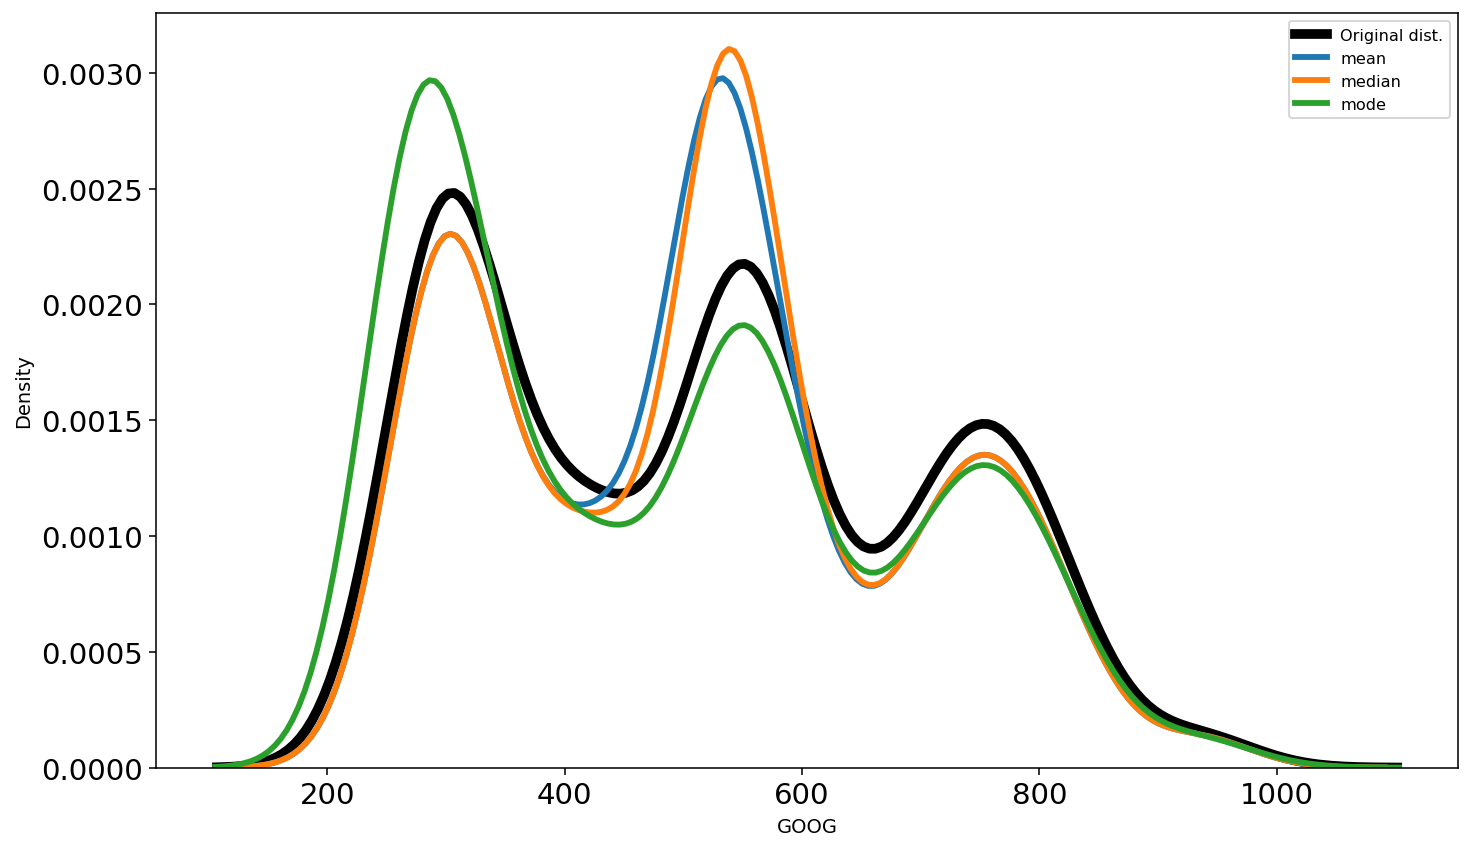

In [34]:
compare_dists(
    clone["GOOG"],
    {"mean": clone["mean"], "median": clone["median"], "mode": clone["most_frequent"]},
)

It is hard to say which lines most closely resembles the black line, but I will go with the green.

In [35]:
# For 2.4
clone.drop(["mean", "median", "most_frequent"], axis=1, inplace=True)

## 2.2 Forward and backward filling

Consider this small distribution:

In [36]:
sample = pd.Series([np.nan, 2, 3, np.nan, 4, np.nan, np.nan, 5, 12, np.nan]).to_frame(
    name="original"
)

In [37]:
sample

,original
0,NaN
1,2.0
2,3.0
3,NaN
4,4.0
5,NaN
6,NaN
7,5.0
8,12.0
9,NaN


We will use both forward and backward filling and assign them back to the DataFrame as separate columns:

In [38]:
sample["ffill"] = sample["original"].ffill()
sample["bfill"] = sample["original"].bfill()

In [39]:
sample

,original,ffill,bfill
0,NaN,NaN,2.0
1,2.0,2.0,2.0
2,3.0,3.0,3.0
3,NaN,3.0,4.0
4,4.0,4.0,4.0
5,NaN,4.0,5.0
6,NaN,4.0,5.0
7,5.0,5.0,5.0
8,12.0,12.0,12.0
9,NaN,12.0,NaN


It should be fairly obvious how these methods work once you examine the above output.

Now, let’s perform these methods on the Airquality in India dataset:

In [40]:
air_q = pd.read_csv(
    "data/station_day.csv",
    usecols=["Date", "NO2"],
    parse_dates=["Date"],
    index_col="Date",
)

In [41]:
for method in ["ffill", "bfill"]:
    air_q[method] = eval(f"air_q['NO2'].{method}()")

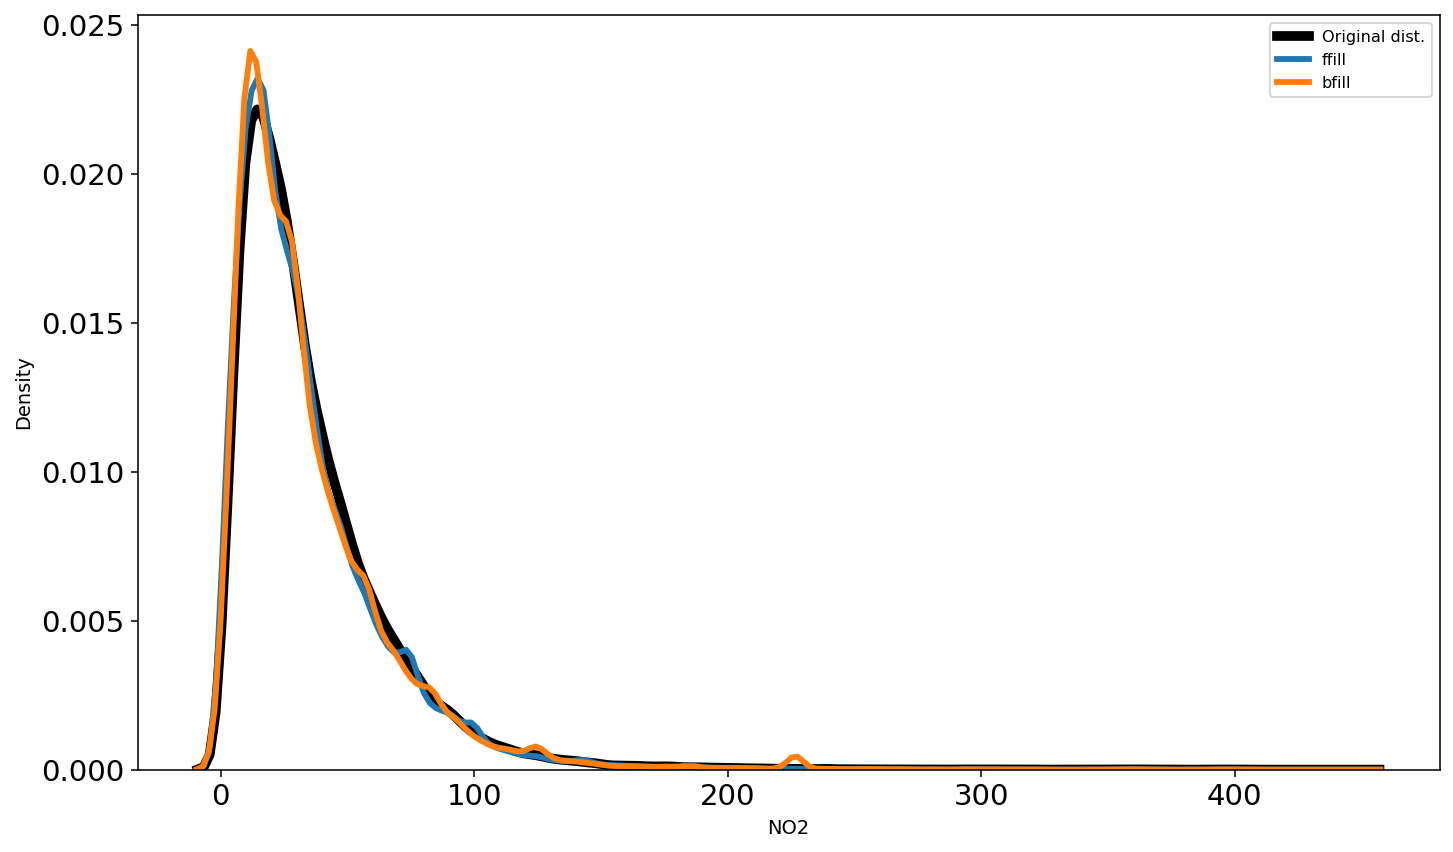

In [42]:
compare_dists(air_q["NO2"], {"ffill": air_q["ffill"], "bfill": air_q["bfill"]})

Even though very basic, forward and backward filling actually works pretty well on climate and stocks data since the differences between nearby data points are small.

## 2.3 Using `pd.interpolate`

Pandas provides a whole suite of other statistical imputation techniques in `pd.interpolate` function. Its `method` parameter accepts the name of the technique as a string.

The most popular ones are ‘linear’ and ‘nearest,’ but you can see the full list from the function’s documentation. Here, we will only discuss those two.

Consider this small distribution:

In [43]:
sample = pd.Series([1] + [np.nan] * 6 + [10]).to_frame(name="original")

In [44]:
sample

,original
0,1.0
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,10.0


Once again, we apply the methods and assign their results back:

In [45]:
sample["linear"] = sample["original"].interpolate(method="linear")
sample["nearest"] = sample["original"].interpolate(method="nearest")

In [46]:
sample

,original,linear,nearest
0,1.0,1.000000,1.0
1,NaN,2.285714,1.0
2,NaN,3.571429,1.0
3,NaN,4.857143,1.0
4,NaN,6.142857,10.0
5,NaN,7.428571,10.0
6,NaN,8.714286,10.0
7,10.0,10.000000,10.0


Neat, huh? The linear method considers the distance between any two non-missing points as linearly spaced and finds a linear line that connects them (like `np.linspace`). 'Nearest' method should be understandable from its name and the above output.

## 2.4 Model-based imputation with KNN

The last method we will see is the K-Nearest-Neighbors algorithm. I won’t detail how the algorithm works but only show how you can use it with Sklearn.

The most important parameter of KNN is `k` - the number of neighbors. We will apply the technique to the first dataset with several values of `k` and find the best one the same way as we did in the previous sections:

In [47]:
from sklearn.impute import KNNImputer

In [48]:
n_neighbors = [2, 3, 5, 7, 9]

for k in n_neighbors:
    imp = KNNImputer(n_neighbors=k)
    clone[f"k={k}"] = imp.fit_transform(clone["GOOG"].values.reshape(-1, 1))

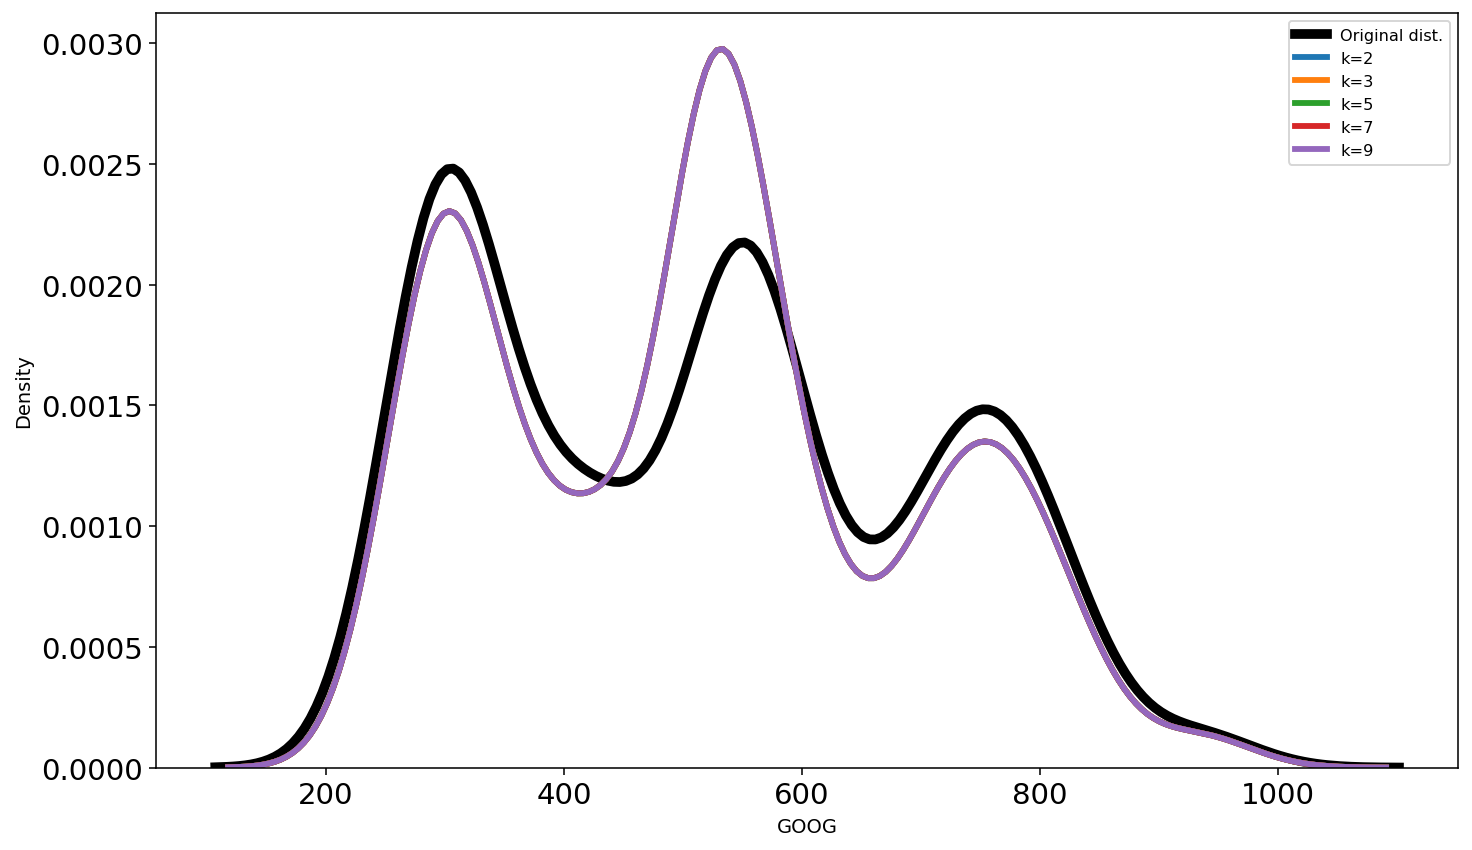

In [49]:
compare_dists(clone["GOOG"], {f"k={k}": clone[f"k={k}"] for k in n_neighbors})

# 3. Basic time series calculations

Pandas offers basic functions to calculate the most common time series calculations. These are called shifts, lags, and something called a percentage change.

## 3.1 Shifts and lags

A common operation in time series is to move all data points one or more periods backward or forward to compare past and future values. You can do these operations using `shift` function of pandas. Let's see how to move the data points 1 and 2 periods into the future:

In [50]:
sp500 = pd.read_csv(
    "data/sp500.csv",
    parse_dates=["date"],
    index_col="date",
)

In [51]:
sp500.head()

,SP500
date,
2007-06-29,1503.35
2007-07-02,1519.43
2007-07-03,1524.87
2007-07-05,1525.40
2007-07-06,1530.44


In [52]:
sp500["shifted_1"] = sp500["SP500"].shift(periods=1)  # the default
sp500["shifted_2"] = sp500["SP500"].shift(periods=2)

In [53]:
sp500.head(6)

,SP500,shifted_1,shifted_2
date,,,
2007-06-29,1503.35,NaN,NaN
2007-07-02,1519.43,1503.35,NaN
2007-07-03,1524.87,1519.43,1503.35
2007-07-05,1525.40,1524.87,1519.43
2007-07-06,1530.44,1525.40,1524.87
2007-07-09,1531.85,1530.44,1525.40


Shifting forward enables you to compare the current data point to those recorded one or more periods before.

You can also shift backward. This operation is also called “lagging”:

In [54]:
sp500.drop(["shifted_1", "shifted_2"], axis=1, inplace=True)

sp500["lagged_1"] = sp500["SP500"].shift(periods=-1)
sp500["lagged_2"] = sp500["SP500"].shift(periods=-2)

In [55]:
sp500.tail(6)

,SP500,lagged_1,lagged_2
date,,,
2016-12-22,2260.96,2263.79,2268.88
2016-12-23,2263.79,2268.88,2249.92
2016-12-27,2268.88,2249.92,2249.26
2016-12-28,2249.92,2249.26,2238.83
2016-12-29,2249.26,2238.83,NaN
2016-12-30,2238.83,NaN,NaN


Shifting backward enables us to see the difference between the current data point and the one that comes one or more periods later.

A common operation after shifting or lagging is finding the difference and plotting it:

In [56]:
sp500.drop("lagged_2", axis=1, inplace=True)

sp500["diff_lag"] = sp500["lagged_1"] - sp500["SP500"]
sp500.head()

,SP500,lagged_1,diff_lag
date,,,
2007-06-29,1503.35,1519.43,16.08
2007-07-02,1519.43,1524.87,5.44
2007-07-03,1524.87,1525.40,0.53
2007-07-05,1525.40,1530.44,5.04
2007-07-06,1530.44,1531.85,1.41


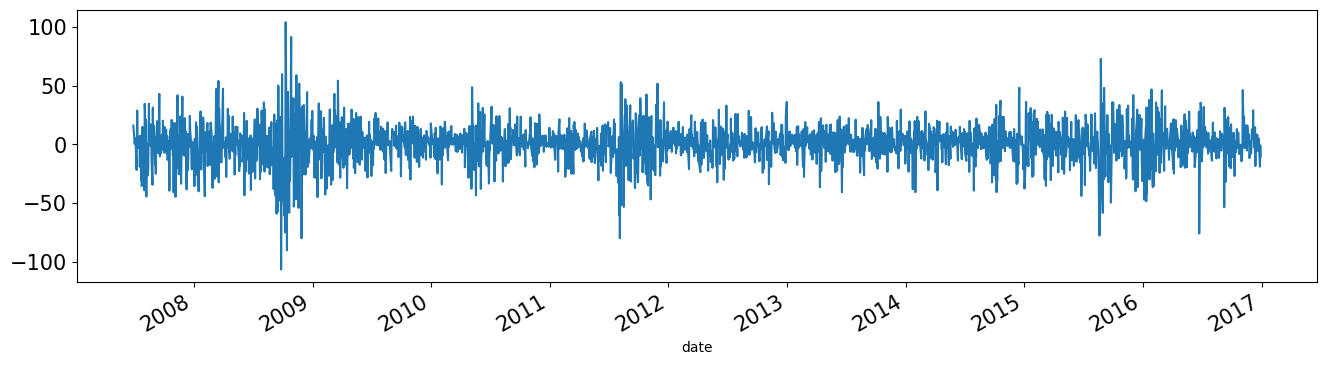

In [57]:
sp500["diff_lag"].plot(figsize=(16, 4));

Since this operation is so common, Pandas has the `diff` function that computes the differences based on the period:

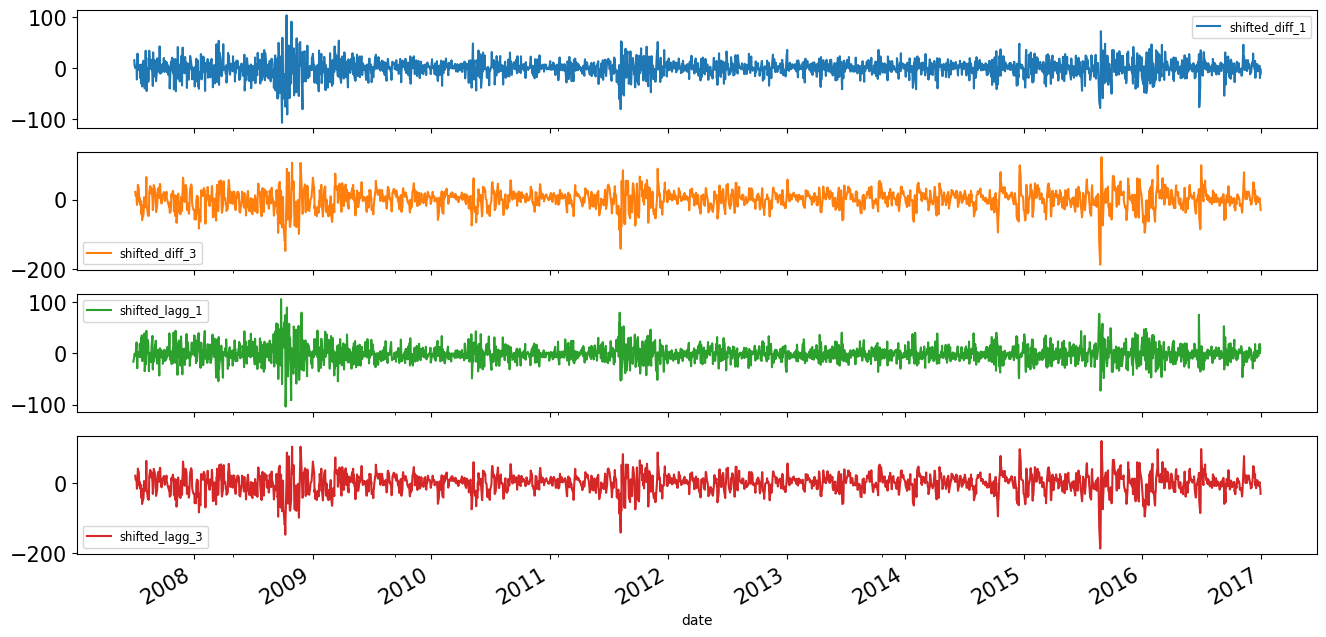

In [58]:
sp500.drop(["lagged_1", "diff_lag"], axis=1, inplace=True)

sp500["shifted_diff_1"] = sp500["SP500"].diff(periods=1)
sp500["shifted_diff_3"] = sp500["SP500"].diff(periods=3)
sp500["shifted_lagg_1"] = sp500["SP500"].diff(periods=-1)
sp500["shifted_lagg_3"] = sp500["SP500"].diff(periods=3)

sp500.drop("SP500", axis=1).plot(figsize=(16, 8), subplots=True);

## 3.2 Percentage changes

Another common metric that can be derived from time-series data is day-to-day percentage change:

In [59]:
sp500.drop(
    ["shifted_diff_1", "shifted_diff_3", "shifted_lagg_1", "shifted_lagg_3"],
    axis=1,
    inplace=True,
)

In [60]:
sp500["shifted"] = sp500["SP500"].shift(1)
sp500["change"] = sp500["SP500"].div(sp500["shifted"]).sub(1).mul(100)

sp500.head()

,SP500,shifted,change
date,,,
2007-06-29,1503.35,NaN,NaN
2007-07-02,1519.43,1503.35,1.069611
2007-07-03,1524.87,1519.43,0.358029
2007-07-05,1525.40,1524.87,0.034757
2007-07-06,1530.44,1525.40,0.330405


To calculate day-to-day percentage change, shift one period forward and divide the original distribution by the shifted one and subtract 1. The resulting values are given as proportions of what they were the day before.

Since it is a common operation, Pandas implements it with the `pct_change` function:

In [61]:
sp500["pct_change"] = sp500["SP500"].pct_change().mul(100)

sp500.head()

,SP500,shifted,change,pct_change
date,,,,
2007-06-29,1503.35,NaN,NaN,NaN
2007-07-02,1519.43,1503.35,1.069611,1.069611
2007-07-03,1524.87,1519.43,0.358029,0.358029
2007-07-05,1525.40,1524.87,0.034757,0.034757
2007-07-06,1530.44,1525.40,0.330405,0.330405


In [62]:
# For 4.1
sp500.drop(["shifted", "change", "pct_change"], axis=1, inplace=True)

# 4. Resampling

Often, you may want to increase or decrease the granularity of time series to generate new insights. These operations are called resampling or changing the frequency of time series, and we will discuss the Pandas functions related to them in this section.

## 4.1 Changing the frequency with `asfreq`

The second dataset does not have a fixed date frequency, i.e., the period difference between each date is not the same:

In [63]:
sp500.head()

,SP500
date,
2007-06-29,1503.35
2007-07-02,1519.43
2007-07-03,1524.87
2007-07-05,1525.40
2007-07-06,1530.44


Let’s fix this by giving it a calendar day frequency (daily):

In [64]:
sp500.asfreq("D").head(7)

,SP500
date,
2007-06-29,1503.35
2007-06-30,NaN
2007-07-01,NaN
2007-07-02,1519.43
2007-07-03,1524.87
2007-07-04,NaN
2007-07-05,1525.40


We just made the frequency of the date more granular. As a result, new dates were added, leading to more missing values. You can now interpolate them using any of the techniques we discussed earlier.

You can see the list of built-in frequency aliases from [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). A more interesting scenario would be using custom frequencies:

In [65]:
# 5-hour frequency
sp500.asfreq("5h").head(7)  # This makes the dataset very large

,SP500
date,
2007-06-29 00:00:00,1503.35
2007-06-29 05:00:00,NaN
2007-06-29 10:00:00,NaN
2007-06-29 15:00:00,NaN
2007-06-29 20:00:00,NaN
2007-06-30 01:00:00,NaN
2007-06-30 06:00:00,NaN


In [66]:
# 10 day frequency
sp500.asfreq("10d", method="ffill").head(7)  # This makes the dataset smaller

,SP500
date,
2007-06-29,1503.35
2007-07-09,1531.85
2007-07-19,1553.08
2007-07-29,1458.95
2007-08-08,1497.49
2007-08-18,1445.94
2007-08-28,1432.36


In [67]:
# 10 month frequency
sp500.asfreq("10M", method="bfill").head(7)

,SP500
date,
2007-06-30,1519.43
2008-04-30,1385.59
2009-02-28,700.82
2009-12-31,1115.10
2010-10-31,1184.38
2011-08-31,1218.89
2012-06-30,1365.51


There is also a `reindex` function that operates similarly and supports additional missing value filling logic. We won't discuss it here as there are better options we will consider.

## 4.2 Downsampling with `resample` and aggregating

In time series lingo, making the frequency of a `DateTime` less granular is called downsampling. The examples are changing the frequency from hourly to daily, from daily to weekly, etc.

We saw how to downsample with `asfreq`. A more powerful alternative is `resample` which behaves like `pd.groupby`. Just like `groupby` groups the data based on categorical values, `resample` groups the data by date frequencies.

Let’s downsample the first dataset by month-end frequency:

In [68]:
aapl_googl.resample("M")

Unlike `asfreq`, using resample only returns the data in the resampled state. To see each group, we need to use some type of function, similar to how we use `groupby`.

Since downsampling decreases the number of data points, we need an aggregation function like mean, median, or mode:

In [69]:
aapl_googl.resample("M").mean().tail()

,AAPL,GOOG
Date,,
2017-01-31,119.570000,807.905000
2017-02-28,133.713684,816.916842
2017-03-31,140.617826,834.111304
2017-04-30,142.886842,844.056842
2017-05-31,152.227727,939.284091


There are also functions that return the first or last record of a group:

In [70]:
# Resample with business-month frequency
# and return the first record of each group
aapl_googl.resample("BM").first().tail()

,AAPL,GOOG
Date,,
2017-01-31,116.15,786.14
2017-02-28,128.75,795.70
2017-03-31,139.79,835.24
2017-04-28,143.70,838.55
2017-05-31,146.58,912.57


In [71]:
# Opposite of first()
aapl_googl.resample("Y").last().tail()  # Year-end frequency

,AAPL,GOOG
Date,,
2013-12-31,80.15,559.79
2014-12-31,110.38,526.40
2015-12-31,105.26,758.88
2016-12-31,115.82,771.82
2017-12-31,152.76,964.86


It is also possible to use multiple aggregating functions using `agg`:

In [72]:
aapl_googl.resample("Y").agg(["mean", "median", "std"]).head()

AAPL                           GOOG                    
                 mean  median        std        mean   median        std
Date                                                                    
2010-12-31  46.217273  46.240   0.238918  299.040000  299.160   2.554451
2011-12-31  52.000357  51.005   3.703047  284.206190  288.435  21.401861
2012-12-31  82.292920  83.210   9.568044  321.086800  316.080  26.439457
2013-12-31  67.519008  65.870   6.412200  441.678294  437.690  49.315266
2014-12-31  92.264683  93.900  13.371014  561.328452  564.535  25.968697

## 4.3 Upsampling with `resample` and interpolating

The opposite of downsampling is making the `DateTime` more granular. This is called upsampling and includes operations like changing the frequency from daily to hourly, hourly to seconds, etc.

When upsampling, you introduce new dates leading to more missing values. This means you need to use some type of imputation:

In [73]:
# Resample with business day freq and forward-fill
aapl_googl.resample("B").ffill().tail()

,AAPL,GOOG
Date,,
2017-05-25,153.87,969.54
2017-05-26,153.61,971.47
2017-05-29,153.61,971.47
2017-05-30,153.67,975.88
2017-05-31,152.76,964.86


In [74]:
# Resample with 20-hour frequency and back-fill
aapl_googl.resample("20h").bfill().sample(5)

,AAPL,GOOG
Date,,
2015-02-07 04:00:00,119.72,527.83
2016-12-13 04:00:00,115.19,797.07
2014-03-26 16:00:00,76.78,556.58
2014-01-08 04:00:00,76.65,564.55
2017-04-24 16:00:00,144.53,872.30


## 4.4 Plotting the resampled data

Resampling isn’t going to give much if you don’t plot its results.

In most cases, you will see new trends and patterns when you downsample. This is because downsampling reduces the granularity, thus eliminating noise:

In [75]:
quarter_google = aapl_googl.resample("Q")["GOOG"].mean()
yearly_google = aapl_googl.resample("Y")["GOOG"].mean()

quarter_apple = aapl_googl.resample("Q")["AAPL"].mean()
yearly_apple = aapl_googl.resample("Y")["AAPL"].mean()

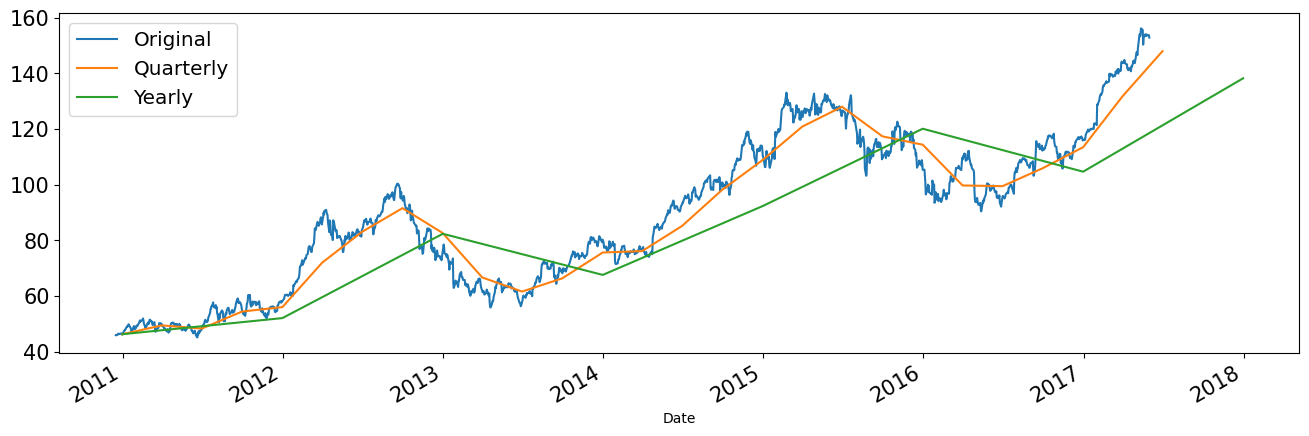

In [76]:
# Plot Apple's downsampled stocks
aapl_googl["AAPL"].plot(figsize=(16, 5), label="Original")
quarter_apple.plot(label="Quarterly")
yearly_apple.plot(label="Yearly")
plt.legend(fontsize="x-large");

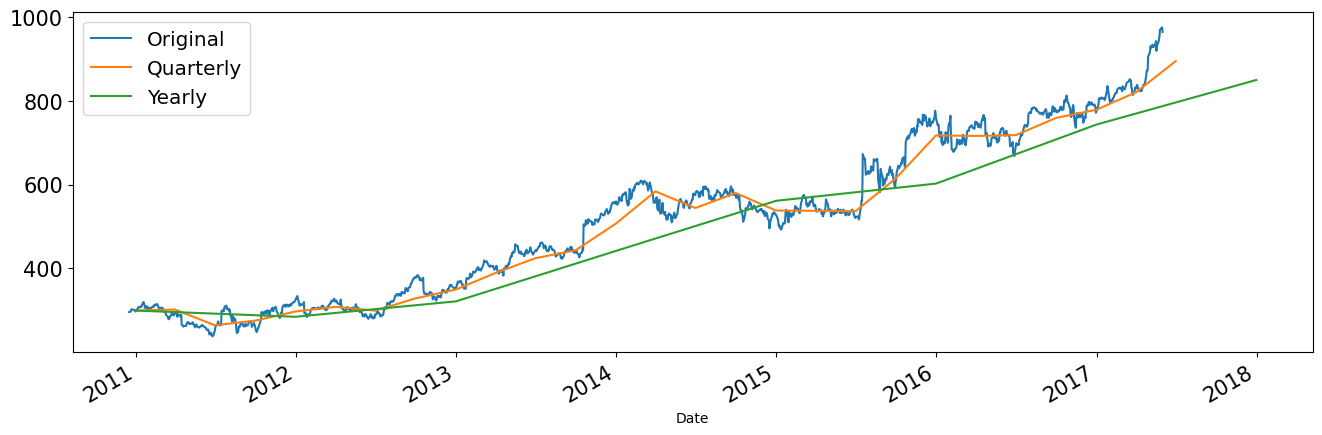

In [77]:
# Plot Google's downsampled stocks
aapl_googl["GOOG"].plot(figsize=(16, 5), label="Original")
quarter_google.plot(label="Quarterly")
yearly_google.plot(label="Yearly")
plt.legend(fontsize="x-large");

Plotting the upsampled distribution is only going to introduce more noise, so we won’t do it here.

# 5. Comparing the growth of multiple time series

It is common to compare two or more numeric values that change over time. For example, we might want to see the growth rate of Google and Apple's stock prices. But here is the problem:

In [78]:
aapl_googl.mean()

AAPL     89.465209
GOOG    513.967180
dtype: float64

Google's stock prices are way higher than Apple's. Plotting the stocks together would probably squish Apple's to a flat line. In other words, the two stocks have different scales.

To fix this, statisticians use normalization. The most common variation is choosing the first recorded value and dividing the rest of the samples by that amount. This shows how each record changes compared to the first.

Here is an example:

In [79]:
aapl_googl.dropna(inplace=True)

# The first rows will contain ones because
# they are being divided by themselvs
aapl_googl.div(aapl_googl.iloc[0]).head(10)

,AAPL,GOOG
Date,,
2010-12-16,1.000000,1.000000
2010-12-17,0.998039,0.998444
2010-12-20,1.003051,1.005650
2010-12-21,1.009370,1.019184
2010-12-22,1.012203,1.023278
2010-12-23,1.007409,1.021146
2010-12-27,1.010678,1.018034
2010-12-28,1.013293,1.012180
2010-12-29,1.012639,1.015699


The above output shows that for the first 3 dates, Apple stocks didn't change. Then, it increased by 1% of what it was on the first date ('2010–12–16'). Google's prices are more volatile, fluctuating between 1 and 2% increases during the first 10 dates.

Now, let's plot them to compare growth:

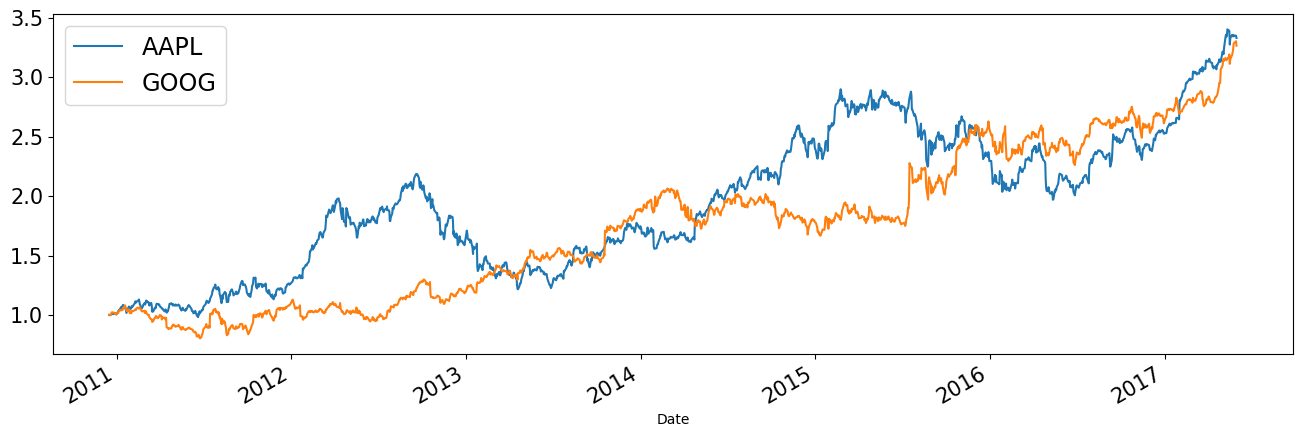

In [80]:
# Normalize
normalized_aapl_goog = aapl_googl.div(aapl_googl.iloc[0])

normalized_aapl_goog.plot(figsize=(16, 5))
plt.legend(fontsize="xx-large");

Both Apple's and Google's achieved over 300% growth from 2011 to 2017. This plot may be even more interesting if we compare their growth to other 500 Fortune Companies:

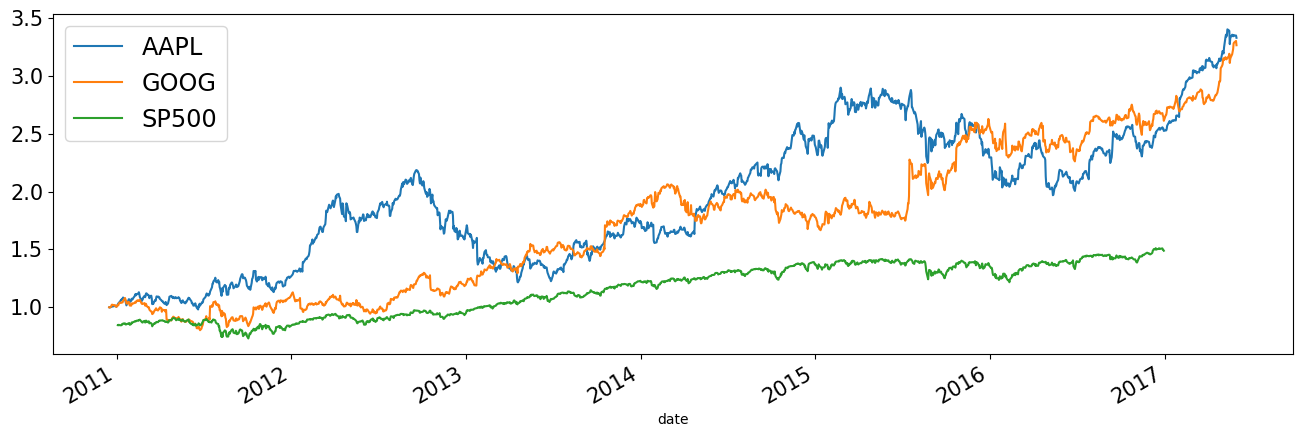

In [81]:
# Normalize SP500 dataset
normalized_sp500 = sp500.div(sp500.iloc[0])

# PLot
fig, ax = plt.subplots(figsize=(16, 5))

normalized_aapl_goog.plot(ax=ax)
normalized_sp500["2011":].plot(label="S&P500", ax=ax)

plt.legend(fontsize="xx-large")

As you can see, Apple and Google have much higher growth than other top 500 companies in the US.

# 6. Window functions

There is another type of function that helps you analyze time-series data in novel ways. These are called window functions, and they help you aggregate over a custom number of rows called ‘windows.’

For example, I can create a 30-day window over my Medium subscribers data to see the total number of subscribers for the past 30 days on any given day. Or a restaurant owner might create a weekly window to see average sales of the past week. Examples are endless as you can create a window of any size over your data.

Let’s explore these in more detail.

## 6.1 Rolling window functions

Rolling window functions will have the same length. As they slide through the data, their coverage (number of rows don’t change). Here is an example window of 5 periods sliding through the data:

<img src="figures/window_function_1.webp" style="width:650px;height:250px;background-color:white">

Here is how we create rolling windows in pandas:

In [82]:
aapl_googl.rolling(window=5)

Rolling [window=5,center=False,axis=0,method=single]

Just like `resample`, it is in a read-only state - to use each window, we should chain some type of function. For example, let's create a cumulative sum for every past 5 periods:

In [83]:
aapl_googl["GOOG_5d_roll"] = aapl_googl["GOOG"].rolling(window=5).sum()

aapl_googl.head(10)

,AAPL,GOOG,GOOG_5d_roll
Date,,,
2010-12-16,45.89,295.56,NaN
2010-12-17,45.80,295.10,NaN
2010-12-20,46.03,297.23,NaN
2010-12-21,46.32,301.23,NaN
2010-12-22,46.45,302.44,1491.56
2010-12-23,46.23,301.81,1497.81
2010-12-27,46.38,300.89,1503.60
2010-12-28,46.50,299.16,1505.53
2010-12-29,46.47,300.20,1504.50


Obviously, the first 4 rows will be NaNs. Any other row will contain the sum of the previous 4 rows and the current one.

Pay attention to the window argument. If you pass an integer, the window size will be determined by that number of rows. If you pass a frequency alias such as months, years, 5 hours, or 7 weeks, the window size will be whatever number of rows that includes the single unit of the passed frequency. In other words, a 5-period window might have a different size than a 5-day frequency window.

As an example, let’s plot 90 and 360-day moving averages for feature 2 and plot them:

In [84]:
aapl_googl["90D_roll_mean"] = aapl_googl["GOOG"].rolling(window="90D").mean()
aapl_googl["360D_roll_mean"] = aapl_googl["GOOG"].rolling(window="360D").mean()

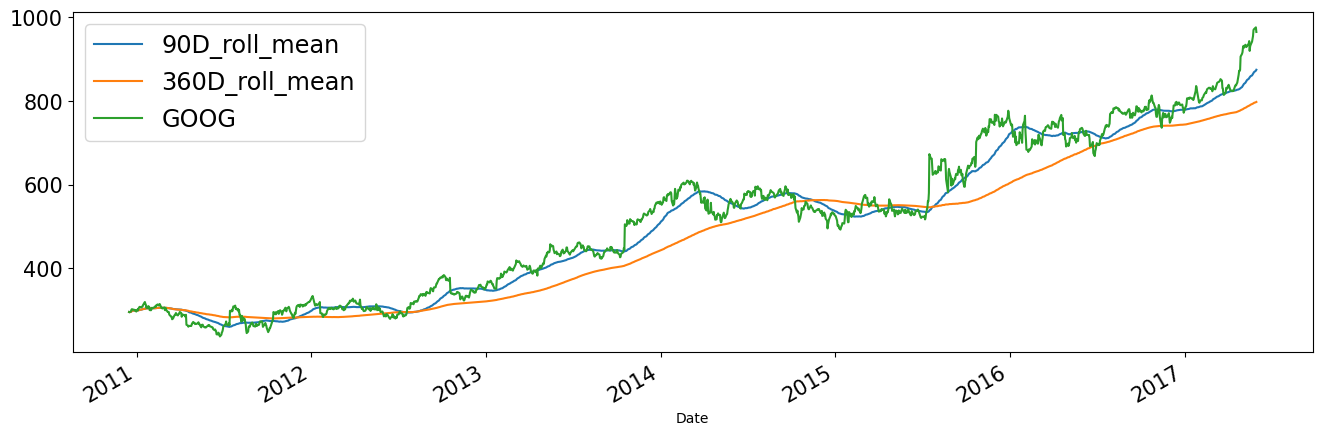

In [85]:
fig, ax = plt.subplots(figsize=(16, 5))

aapl_googl[["90D_roll_mean", "360D_roll_mean", "GOOG"]].plot(ax=ax)

plt.legend(fontsize="xx-large");

## 6.2 Expanding window functions

Another type of window function deals with expanding windows. Each new window will contain all the records up to the current date:

<img src="figures/window_function_2.webp" style="width:650px;height:250px;background-color:white">

Expanding windows are useful for calculating ‘running’ metrics-for example, running sum, mean, min and max, running rate of return, etc.

Below, you will see how to calculate the cumulative sum. The cumulative sum is actually an expanding window function with a window size of 1:

In [86]:
aapl_googl.drop(
    ["GOOG_5d_roll", "90D_roll_mean", "360D_roll_mean"], axis=1, inplace=True
)

In [87]:
aapl_googl["expanding_cumsum"] = aapl_googl["GOOG"].expanding(min_periods=1).sum()
# The same operation with cumsum() func
aapl_googl["cumsum_function"] = aapl_googl["GOOG"].cumsum()

aapl_googl.head()

,AAPL,GOOG,expanding_cumsum,cumsum_function
Date,,,,
2010-12-16,45.89,295.56,295.56,295.56
2010-12-17,45.80,295.10,590.66,590.66
2010-12-20,46.03,297.23,887.89,887.89
2010-12-21,46.32,301.23,1189.12,1189.12
2010-12-22,46.45,302.44,1491.56,1491.56


`expanding` function has a `min_periods` parameter that determines the initial window size.

Now, let’s see how to plot the running min and max:

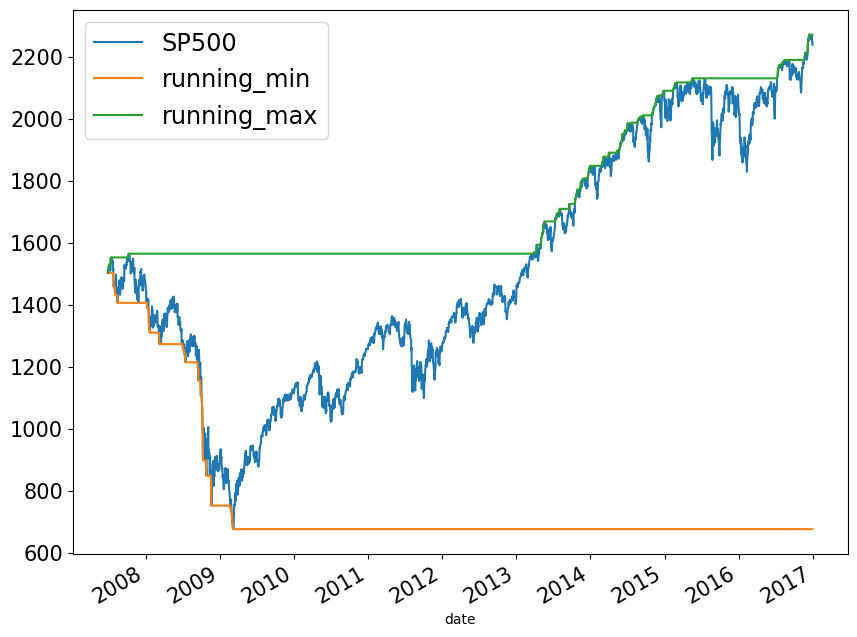

In [88]:
sp500["running_min"] = sp500["SP500"].expanding().min()  # same as cummin()
sp500["running_max"] = sp500["SP500"].expanding().max()

fig, ax = plt.subplots(figsize=(10, 8))

sp500.plot(ax=ax)
plt.legend(fontsize="xx-large");